In [1]:
import pyvisa
import numpy as np
import time
rm = pyvisa.ResourceManager()
print(rm.list_resources())


('USB0::0x05E6::0x2470::04625649::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR', 'ASRL5::INSTR', 'ASRL7::INSTR', 'ASRL8::INSTR')


In [2]:
class Keithley2470:
    class_verbose = True
    def __init__(self, address, timeout=20000):
        self.address = address
        self.instrument = rm.open_resource(self.address)
        self.instrument.timeout = timeout
        self.instrument.read_termination = '\n'
        self.instrument.write_termination = '\n'


    ## METHODS ##
    def reset(self):
        print("Resetting the instrument")
        self.instrument.write("*RST;:STAT:PRES;:*CLS;")

    def beep(self, frequency, duration):
        print(f"Beeping at {frequency} Hz for {duration} seconds")
        self.instrument.write(f":SYST:BEEP {frequency:g}, {duration:g}")

    def use_front_terminals(self):
        print("Using front terminals")
        self.instrument.write(":ROUT:TERM FRON")

    def use_rear_terminals(self):
        print("Using rear terminals")
        self.instrument.write(":ROUT:TERM REAR")

    def get_idn(self):
        return self.instrument.query("*IDN?")

    def write(self, command: str, verbose=class_verbose) -> None:
        self.instrument.write(command)
        if verbose:
            print(f"Sent: {command}")

    def query(self, command: str, verbose = class_verbose) -> str:
        if verbose:
            print(f"Query: {command}")
        return self.instrument.query(command)

    def disconnect(self) -> None:
        self.instrument.close()


In [9]:
# Testing multiple commands
KEITHLEY_2470_ADDRESS = 'USB0::0x05E6::0x2470::04625649::INSTR'
keithley = Keithley2470(KEITHLEY_2470_ADDRESS)

keithley.reset() # Reset the instrument
base_freq = 500
triad_command = f"""
:SYST:BEEP {base_freq}, 0.5
:SYST:BEEP {base_freq*5.0/4.0}, 0.5
:SYST:BEEP {base_freq*6.0/4.0}, 0.5
"""
keithley.write(triad_command) # Beep twice

Resetting the instrument
Sent: 
:SYST:BEEP 500, 0.5
:SYST:BEEP 625.0, 0.5
:SYST:BEEP 750.0, 0.5



C:\Users\10552\AppData\Local\Temp\ipykernel_23832\3897023936.py:32: UserWarning: write message already ends with termination characters
  self.instrument.write(command)


In [24]:
KEITHLEY_2470_ADDRESS = 'USB0::0x05E6::0x2470::04625649::INSTR'
keithley = Keithley2470(KEITHLEY_2470_ADDRESS)
keithley.reset()
keithley.beep(500, 0.5)
idn = keithley.get_idn()
print(f"Connected to: {idn}")

keithley.use_front_terminals()
keithley.write(":SOUR:FUNC VOLT")
keithley.write(":SENSE:FUNC 'CURR'")
keithley.write(":SOUR:VOLT:ILIMIT 0.1")
keithley.write(":CURR:RANGE:AUTO ON")
keithley.write(":SENS:CURR:NPLC 1")

Voltages = np.arange(-1.0, 1.5, 0.5)
Voltages_b = np.arange(1.5, 2.1, 0.1)
Voltages = np.concatenate((Voltages, Voltages_b))
Currents = np.ones(len(Voltages))
print(Voltages)
for i, voltage in enumerate(Voltages):
    keithley.write(":SOUR:VOLT {}".format(voltage))
    keithley.write(":OUTP ON")
    output = keithley.query(":READ?")
    output = float(output)
    Currents[i] = output
    print(f"Voltage: {voltage} V")
    print(f"Output: {output*1e3:.2f} mA")
    time.sleep(0.5)
    keithley.beep(300+i*20, 0.5)
    # keithley.write(":OUTP OFF")
    # time.sleep(0.5)

keithley.write(":OUTP OFF")
keithley.disconnect()


Resetting the instrument
Beeping at 500 Hz for 0.5 seconds
Connected to: KEITHLEY INSTRUMENTS,MODEL 2470,04625649,1.7.14j
Using front terminals
[-1.  -0.5  0.   0.5  1.   1.5  1.6  1.7  1.8  1.9  2.   2.1]
Voltage: -1.0 V
Output: -0.00 mA
Beeping at 300 Hz for 0.5 seconds
Voltage: -0.5 V
Output: -0.00 mA
Beeping at 320 Hz for 0.5 seconds
Voltage: 0.0 V
Output: -0.00 mA
Beeping at 340 Hz for 0.5 seconds
Voltage: 0.5 V
Output: -0.00 mA
Beeping at 360 Hz for 0.5 seconds
Voltage: 1.0 V
Output: -0.00 mA
Beeping at 380 Hz for 0.5 seconds
Voltage: 1.5 V
Output: 0.01 mA
Beeping at 400 Hz for 0.5 seconds
Voltage: 1.6 V
Output: 0.11 mA
Beeping at 420 Hz for 0.5 seconds
Voltage: 1.7000000000000002 V
Output: 1.22 mA
Beeping at 440 Hz for 0.5 seconds
Voltage: 1.8000000000000003 V
Output: 5.60 mA
Beeping at 460 Hz for 0.5 seconds
Voltage: 1.9000000000000004 V
Output: 13.07 mA
Beeping at 480 Hz for 0.5 seconds
Voltage: 2.0000000000000004 V
Output: 22.26 mA
Beeping at 500 Hz for 0.5 seconds
Voltage: 2

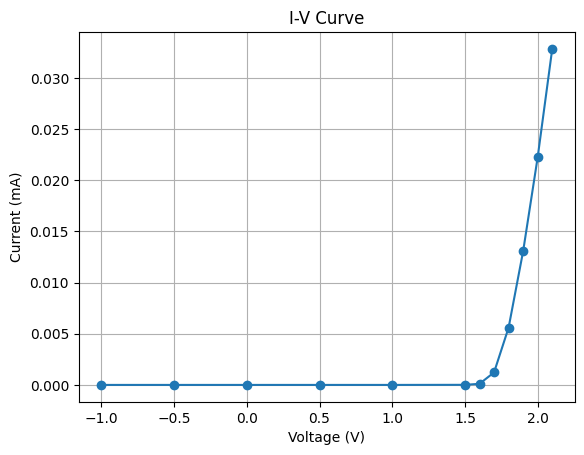

In [25]:
import matplotlib.pyplot as plt
# plt.plot(Voltages*(-1.0), Currents*(-1.0), '-o')
plt.plot(Voltages, Currents, '-o')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (mA)')
plt.title('I-V Curve')
plt.grid()
plt.show()

In [8]:
KEITHLEY_2470_ADDRESS = 'USB0::0x05E6::0x2470::04625649::INSTR'
keithley = Keithley2470(KEITHLEY_2470_ADDRESS)
keithley.reset()
keithley.beep(500, 0.5)
idn = keithley.query("*IDN?")

keithley.use_front_terminals()
keithley.write(":SOURce:FUNC VOLT") # Set device to source voltage
keithley.write(":SENSe:FUNC 'CURR'") # Set device to measure current
keithley.write(":CURRent:RANGE 0.5") # Set current range to 0.1 A

keithley.write(":SOURce:VOLT:ILIMIT 0.5") # Set current limit to 0.1 A
# keithley.write(":CURR:RANGE:AUTO OFF") # Set current range to auto
keithley.write(":SENSe:CURRent:NPLC 3") # NLPC means number of power line cycles

Voltages = np.arange(-1.0, 1.5, 0.5)
Voltages_b = np.arange(1.5, 2.1, 0.1)
Voltages = np.concatenate((Voltages, Voltages_b))
Currents = np.ones(len(Voltages))
print(Voltages)
for i, voltage in enumerate(Voltages):
    keithley.write(":SOURce:VOLT {}".format(voltage))
    keithley.write(":OUTP ON")
    output = keithley.query(":READ?")
    output = float(output)
    Currents[i] = output
    # print(f"Voltage: {voltage} V")
    # print(f"Output: {output*1e3:.2f} mA")
    time.sleep(0.5)
    keithley.beep(300+i*20, 0.5)


keithley.write(":OUTP OFF")
keithley.disconnect()


Resetting the instrument
Beeping at 500 Hz for 0.5 seconds
Query: *IDN?
Using front terminals
Sent: :SOURce:FUNC VOLT
Sent: :SENSe:FUNC 'CURR'
Sent: :CURRent:RANGE 0.5
Sent: :SOURce:VOLT:ILIMIT 0.5
Sent: :SENSe:CURRent:NPLC 3
[-1.  -0.5  0.   0.5  1.   1.5  1.6  1.7  1.8  1.9  2.   2.1]
Sent: :SOURce:VOLT -1.0
Sent: :OUTP ON
Query: :READ?
Beeping at 300 Hz for 0.5 seconds
Sent: :SOURce:VOLT -0.5
Sent: :OUTP ON
Query: :READ?
Beeping at 320 Hz for 0.5 seconds
Sent: :SOURce:VOLT 0.0
Sent: :OUTP ON
Query: :READ?
Beeping at 340 Hz for 0.5 seconds
Sent: :SOURce:VOLT 0.5
Sent: :OUTP ON
Query: :READ?
Beeping at 360 Hz for 0.5 seconds
Sent: :SOURce:VOLT 1.0
Sent: :OUTP ON
Query: :READ?
Beeping at 380 Hz for 0.5 seconds
Sent: :SOURce:VOLT 1.5
Sent: :OUTP ON
Query: :READ?
Beeping at 400 Hz for 0.5 seconds
Sent: :SOURce:VOLT 1.6
Sent: :OUTP ON
Query: :READ?
Beeping at 420 Hz for 0.5 seconds
Sent: :SOURce:VOLT 1.7000000000000002
Sent: :OUTP ON
Query: :READ?
Beeping at 440 Hz for 0.5 seconds
Sent: :

### SCPI Commands explained
`:TRACE:DATA? 1, 10, 'name' ,READ, REL"`
- `:TRACE:DATA?` is the base command for retrieving data from a reading buffer.
- `1, 10` specifies the range of readings to retrieve. In this case, it's requesting readings 1 through 10 from the buffer.
- `name` is a placeholder for the actual name of the reading buffer you want to access. You would replace this with the specific buffer name you're using.
- `READ, REL` are the data elements being requested:
    - `READ` refers to the actual readings stored in the buffer.
    - `REL` stands for "Relative Timestamp," which provides the time elapsed between readings.

`:TRIG:LOAD "DurationLoop", 8, 0.1`
- `'DurationLoop', T, dt`
- `T` is the total time of the loop
- `dt` is the time interval between each reading

In [51]:
KEITHLEY_2470_ADDRESS = 'USB0::0x05E6::0x2470::04625649::INSTR'
keithley = Keithley2470(KEITHLEY_2470_ADDRESS)
keithley.beep(500, 0.5)
# idn = keithley.query("*IDN?")
# print(f"Connected to: {idn}")

# keithley.write("*RST") # Reset the instrument
keithley.reset() # Reset the instrument
keithley.write(":SOURce:FUNC VOLT") # Set device to source voltage
keithley.write(":SOUR:VOLT 1.8") # Set voltage to 2.0 V
keithley.write(":SOUR:VOLT:ILIMIT 0.5") # Set current limit to 0.5 A
keithley.write(':SENSE:FUNC "CURR"') # Set device to measure current
keithley.write(":ROUT:TERM FRON") # Use front terminals
keithley.write(":CURR:RANG:AUTO ON") # Set current range to auto 
keithley.write(":SENSE:CURR:NPLC 1") # NLPC means number of power line cycles

# 'DurationLoop', T, dt
# T is the total time of the loop
# dt is the time interval between each reading

keithley.write(':TRIG:LOAD "DurationLoop", 8, 0.1') # Load the DurationLoop trigger model 
time.sleep(1)
keithley.write(":INIT") # Initialize the trigger model
keithley.write("*WAI") # wait for the measurement to finish
time.sleep(1)
# Query the number of readings in debuffer1 and return the readings and return the readings and time. 
# 30 is the queried nmber of readings

# act is the number of data points in debuffer1
act = keithley.query(":TRACE:ACT? 'defbuffer1'") # retrieve activation status of debuffer1

# data_original = keithley.query(":TRACE:DATA? 1, 10,'defbuffer1',READ, REL") # Query the readings in debuffer1
data_original = keithley.query(f":TRACE:DATA? 1, {int(act)}, 'defbuffer1', READ, REL") # Query the readings in debuffer1
#":TRACE:DATA? 1, 10, 'name' ,READ, REL"

keithley.write(":SOURCE:VOLT 0") 
keithley.write(":OUTP ON") # 
keithley.write(":SOURCE:VOLT:DEL 2") # Set the voltage delay to 2 s
keithley.write(":OUTP OFF")


Beeping at 500 Hz for 0.5 seconds
Resetting the instrument
Sent: :SOURce:FUNC VOLT
Sent: :SOUR:VOLT 1.8
Sent: :SOUR:VOLT:ILIMIT 0.5
Sent: :SENSE:FUNC "CURR"
Sent: :ROUT:TERM FRON
Sent: :CURR:RANG:AUTO ON
Sent: :SENSE:CURR:NPLC 1
Sent: :TRIG:LOAD "DurationLoop", 8, 0.1
Sent: :INIT
Sent: *WAI
Query: :TRACE:ACT? 'defbuffer1'
Query: :TRACE:DATA? 10, 45, 'defbuffer1', READ, REL
Sent: :SOURCE:VOLT 0
Sent: :OUTP ON
Sent: :SOURCE:VOLT:DEL 2
Sent: :OUTP OFF


In [53]:
print(type(act))
print(f"act: {act}")
print(data_original)
data_split = data_original.split(',')
print(data_split)
print(len(data_split))
print(len(data_split)/2)

<class 'str'>
act: 45
5.692619E-03,1.523825E+00,5.694312E-03,1.693125E+00,5.695987E-03,1.862420E+00,5.697615E-03,2.031715E+00,5.699138E-03,2.201030E+00,5.700798E-03,2.370350E+00,5.702227E-03,2.539656E+00,5.703717E-03,2.708982E+00,5.705094E-03,2.878285E+00,5.706538E-03,3.047609E+00,5.707812E-03,3.216907E+00,5.709130E-03,3.386202E+00,5.710451E-03,3.555508E+00,5.711705E-03,3.724814E+00,5.712936E-03,3.894112E+00,5.714361E-03,4.063402E+00,5.715516E-03,4.232726E+00,5.716809E-03,4.402032E+00,5.717970E-03,4.571319E+00,5.719077E-03,4.740647E+00,5.720359E-03,4.909954E+00,5.721559E-03,5.079266E+00,5.722751E-03,5.248584E+00,5.723835E-03,5.417879E+00,5.725146E-03,5.587205E+00,5.726130E-03,5.756528E+00,5.727241E-03,5.925847E+00,5.728194E-03,6.095146E+00,5.729381E-03,6.264466E+00,5.730474E-03,6.433782E+00,5.731433E-03,6.603103E+00,5.732629E-03,6.772422E+00,5.733611E-03,6.941730E+00,5.734686E-03,7.111039E+00,5.735539E-03,7.280333E+00,5.736546E-03,7.449634E+00
['5.692619E-03', '1.523825E+00', '5.694312

In [49]:
if isinstance(data_original, str):
    data = data_original.split(',')
    data = [float(i) for i in data]
    # organize the data into tuples
    data = [data[i:i+2] for i in range(0, len(data), 2)]
currents = [entry[0] for entry in data]
times = [entry[1] for entry in data]
    

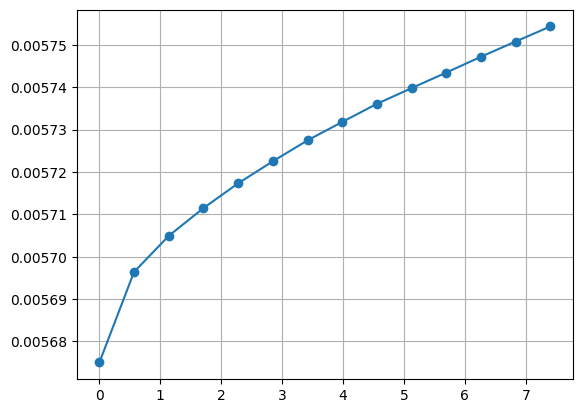

In [50]:
import matplotlib.pyplot as plt
plt.plot(times, currents, '-o')
plt.grid()
plt.show()

In [28]:
import pyvisa

class Instrument:
    def __init__(self,
                 com_port: str | None = None,
                 ip_address: str | None = None,
                 tcp_port: int | None = None,
                 **kwargs) -> None:
        if com_port is not None and ip_address is None and tcp_port is None:
            # port_number = ''.join(s for s in com_port if s.isdigit())
            # resource_name = f"ASRL{port_number}::INSTR"
            resource_name = 'USB0::0x05E6::0x2470::04625649::INSTR'

        elif ip_address is not None and com_port is None:
            if tcp_port is None:
                resource_name = f"TCPIP::{ip_address}::inst0::INSTR"
            else:
                resource_name = f"TCPIP0::{ip_address}::{tcp_port}::SOCKET"
        elif com_port == "USB":
            # resource_name = 'USB0::0x05E6::0x2470::04625649::INSTR'
            resource_name = 'USB0::0x05E6::0x2470::04625649::INSTR'
            print("connecting through USB")
        else:
            raise NameError("Invalid arguments: either 'com_port' is given for"
                            " serial connection or both 'ip_address' and "
                            "'tcp_port' are given for socket connection.")
        # self._instrument = pyvisa.ResourceManager().open_resource(
        #     resource_name=resource_name,
        #     write_termination='\n',
        #     read_termination='\n',
        #     **kwargs
        #     )
        self._instrument = pyvisa.ResourceManager().open_resource(resource_name)

        self._check_connection()

    def _check_connection(self):
        idn = self.query("*IDN?")
        if idn:
            self._idn = idn
            print(f"Connected to {idn}.")
        else:
            self.disconnect()
            print("Instrument could not be identified.")

    def write(self, command: str) -> None:
        self._instrument.write(command)

    def query(self, command: str) -> str:
        return self._instrument.query(command)

    def disconnect(self) -> None:
        self._instrument.close()


In [29]:
instrument = Instrument(com_port="USB")


Connected to KEITHLEY INSTRUMENTS,MODEL 2470,04625649,1.7.14j
.
